# First function

Read in data

In [148]:
import pandas as pd
import numpy as np

In [149]:
ecommerce_data = pd.read_pickle("data/ecommerce_data_1.pkl")

In [150]:
ecommerce_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDateTime,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01,2.55,17850,United Kingdom,2010-12-01 08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01,2.75,17850,United Kingdom,2010-12-01 08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01,3.39,17850,United Kingdom,2010-12-01 08:26:00,20.34
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09,0.85,12680,France,2011-12-09 12:50:00,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09,2.10,12680,France,2011-12-09 12:50:00,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09,4.15,12680,France,2011-12-09 12:50:00,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09,4.15,12680,France,2011-12-09 12:50:00,16.60


In [151]:
# floor date to month
ecommerce_data['date_input'] = ecommerce_data['InvoiceDateTime'].dt.to_period('M').dt.to_timestamp()

In [152]:
user_data_aggrigation = ecommerce_data.groupby(['date_input', 'CustomerID']).agg(
    n = ('CustomerID', 'count'),
    nunique = ('CustomerID', 'nunique')
).reset_index()

In [153]:
from typing import Tuple, Optional, Union, Literal
import pandas as pd
import numpy as np
from datetime import datetime

def generate_cohort_data(
    data: pd.DataFrame, 
    datetime_column_name: str,
    user_column_name: str, 
    value_column_name: Optional[str] = None,
    aggregation_function: Literal['sum', 'mean', 'count', 'median', 'min', 'max', 'nunique'] = 'sum',
    base_period: Literal['D', 'W', 'M', 'Q', 'Y'] = 'M', 
    period_duration: int = 30,
    output_format: Literal['long', 'pivot'] = 'pivot'
) -> pd.DataFrame:
    """
    Creates cohort analysis data in a specified format with optimized performance.
    Supports both user retention analysis and transaction value analysis.
    
    Parameters:
    -----------
    data : pd.DataFrame
        The input data containing transaction information
    datetime_column_name : str
        Column name containing the datetime information
    user_column_name : str
        Column name containing the user/customer ID
    value_column_name : Optional[str], default None
        Column name containing values to aggregate (e.g., transaction amount)
        If None, the function counts unique users (traditional cohort analysis)
    aggregation_function : {'sum', 'mean', 'count', 'median', 'min', 'max', 'nunique'}, default 'sum'
        Function to apply when aggregating values
        Only used when value_column_name is provided
        'nunique' counts the number of unique values in each group
    base_period : {'D', 'W', 'M', 'Q', 'Y'}, default 'M'
        Period to group dates by
    period_duration : int, default 30
        Number of days to consider as one period
    output_format : {'long', 'pivot'}, default 'pivot'
        Format of the output data - long format or pivot table
        
    Returns:
    --------
    pd.DataFrame
        Either a long-format DataFrame with columns [first_period, period_number, metric_value]
        or a pivoted DataFrame in triangle format with cohorts as rows and periods as columns
        
    Examples:
    ---------
    # User retention analysis
    >>> user_cohorts = generate_cohort_data(
    ...     data=df, 
    ...     datetime_column_name='purchase_date',
    ...     user_column_name='customer_id'
    ... )
    
    # Transaction value analysis
    >>> revenue_cohorts = generate_cohort_data(
    ...     data=df, 
    ...     datetime_column_name='purchase_date',
    ...     user_column_name='customer_id',
    ...     value_column_name='purchase_amount',
    ...     aggregation_function='sum'
    ... )
    
    # Count unique products per cohort period
    >>> unique_products = generate_cohort_data(
    ...     data=df,
    ...     datetime_column_name='purchase_date',
    ...     user_column_name='customer_id',
    ...     value_column_name='product_id',
    ...     aggregation_function='nunique'
    ... )
    """
    # Input validation
    if datetime_column_name not in data.columns:
        raise ValueError(f"Column '{datetime_column_name}' not found in data")
    if user_column_name not in data.columns:
        raise ValueError(f"Column '{user_column_name}' not found in data")
    if not pd.api.types.is_datetime64_any_dtype(data[datetime_column_name]):
        raise TypeError(f"Column '{datetime_column_name}' must be of datetime type")
    if output_format not in ['long', 'pivot']:
        raise ValueError("output_format must be either 'long' or 'pivot'")
    
    # Validate value_column if provided
    if value_column_name is not None and value_column_name not in data.columns:
        raise ValueError(f"Column '{value_column_name}' not found in data")
    
    # Create an explicit copy of only the required columns to avoid SettingWithCopyWarning
    required_cols = [datetime_column_name, user_column_name]
    if value_column_name is not None:
        required_cols.append(value_column_name)
    base_data = data[required_cols].copy()
    
    # Set pandas option to suppress the warning (optional)
    pd.options.mode.chained_assignment = None
    
    try:
        # Convert datetime to period and back to timestamp in one efficient operation
        period_col = 'period_date'
        base_data[period_col] = pd.to_datetime(
            base_data[datetime_column_name].dt.to_period(base_period).dt.to_timestamp()
        )
        
        # Get first period for each user using transform (avoids merge operation)
        first_period_col = 'first_period'
        base_data[first_period_col] = base_data.groupby(user_column_name)[period_col].transform('min')
        
        # Calculate days since first purchase and period number in vectorized operations
        first_purchase_dates = base_data.groupby(user_column_name)[datetime_column_name].transform('min')
        base_data['days_since_first_purchase'] = (base_data[datetime_column_name] - first_purchase_dates).dt.days
        base_data['period_number'] = base_data['days_since_first_purchase'] // period_duration
        
        # Calculate the metric based on presence of value_column_name
        if value_column_name is None:
            # Count unique users per cohort and period
            cohort_data_long = base_data.groupby([first_period_col, 'period_number'])[user_column_name].nunique().reset_index(
                name='metric_value'
            )
        else:
            # Apply the specified aggregation function to the value column
            cohort_data_long = base_data.groupby([first_period_col, 'period_number'])[value_column_name].agg(aggregation_function).reset_index(
                name='metric_value'
            )
        
        if output_format == 'pivot':
            # Create the pivot table for the triangle view
            cohort_data_pivot = cohort_data_long.pivot(
                index=first_period_col,
                columns='period_number',
                values='metric_value'
            ).fillna(0)
            
            # Convert to int for user counts, leave as float for value metrics
            if value_column_name is None or (aggregation_function in ['count', 'nunique'] and not pd.api.types.is_float_dtype(data[value_column_name])):
                cohort_data_pivot = cohort_data_pivot.astype(np.int32)
            
            return cohort_data_pivot
        else:
            return cohort_data_long
        
    finally:
        # Reset pandas option to default
        pd.options.mode.chained_assignment = 'warn'

In [154]:
generated_data_long_user = generate_cohort_data(
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    base_period = 'M',
    period_duration = 30,
    output_format = 'long'
)

In [155]:
generated_data_long_user

,first_period,period_number,metric_value
0,2010-12-01,0,948
1,2010-12-01,1,352
2,2010-12-01,2,334
3,2010-12-01,3,370
4,2010-12-01,4,326
...,...,...,...
86,2011-10-01,1,77
87,2011-10-01,2,6
88,2011-11-01,0,321
89,2011-11-01,1,12


In [ ]:
generated_data_pivot_user = generate_cohort_data(
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    base_period = 'M',
    period_duration = 30,
    output_format = 'pivot'
)

In [157]:
generated_data_pivot_user

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
first_period,,,,,,,,,,,,,
2010-12-01,948,352,334,370,326,358,355,331,330,366,382,476,182
2011-01-01,421,107,118,127,126,124,102,113,139,144,131,13,0
2011-02-01,380,84,92,110,80,100,91,112,107,100,12,0,0
2011-03-01,440,81,106,100,89,89,110,117,97,20,0,0,0
2011-04-01,299,80,54,66,54,69,74,72,10,0,0,0,0
2011-05-01,279,56,42,56,69,61,78,6,0,0,0,0,0
2011-06-01,235,39,49,59,66,69,8,0,0,0,0,0,0
2011-07-01,191,34,40,46,46,2,0,0,0,0,0,0,0
2011-08-01,167,35,50,39,3,0,0,0,0,0,0,0,0


In [158]:
gerated_data_long_transaction_sum = generate_cohort_data(
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    value_column_name = 'TotalPrice',
    aggregation_function = 'sum',
    base_period = 'M',
    period_duration = 30,
    output_format = 'long'
)

In [159]:
gerated_data_long_transaction_sum

,first_period,period_number,metric_value
0,2010-12-01,0,589533.18
1,2010-12-01,1,269399.16
2,2010-12-01,2,234009.12
3,2010-12-01,3,311793.00
4,2010-12-01,4,209192.20
...,...,...,...
86,2011-10-01,1,29993.25
87,2011-10-01,2,1271.54
88,2011-11-01,0,143175.78
89,2011-11-01,1,4381.07


In [160]:
generated_data_pivot_transaction_sum = generate_cohort_data(
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    value_column_name = 'TotalPrice',
    aggregation_function = 'sum',
    base_period = 'M',
    period_duration = 30,
    output_format = 'pivot'
)

In [161]:
generated_data_pivot_transaction_sum

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
first_period,,,,,,,,,,,,,
2010-12-01,589533.180,269399.16,234009.12,311793.00,209192.20,298263.34,315586.11,332821.53,287860.590,459076.60,450068.79,491361.96,152318.74
2011-01-01,217959.240,76221.67,50863.08,60313.78,73463.41,83480.05,60478.38,86223.89,78520.991,94758.53,106628.67,9581.39,0.00
2011-02-01,158592.820,34747.95,39150.70,43757.82,28229.15,37402.11,41966.76,58180.63,58234.550,43298.00,5255.28,0.00,0.00
2011-03-01,202336.500,30528.95,51142.47,42600.30,43798.22,42942.82,58424.96,66458.42,49548.580,4472.77,0.00,0.00,0.00
2011-04-01,126913.811,31787.90,21765.42,24104.94,21972.97,30471.89,34360.73,26274.30,3037.780,0.00,0.00,0.00,0.00
2011-05-01,121959.380,20257.09,18214.37,18795.77,31262.29,23302.92,35338.34,1869.05,0.000,0.00,0.00,0.00,0.00
2011-06-01,99219.790,13094.42,13883.84,31828.97,28254.23,33657.50,2610.58,0.00,0.000,0.00,0.00,0.00,0.00
2011-07-01,72826.021,11542.39,16063.94,16713.44,16932.20,194.14,0.00,0.00,0.000,0.00,0.00,0.00,0.00
2011-08-01,88512.100,25411.29,44150.28,24440.27,1112.93,0.00,0.00,0.00,0.000,0.00,0.00,0.00,0.00


In [162]:
gerated_data_long_transaction_unique = generate_cohort_data(
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    value_column_name = 'InvoiceNo',
    aggregation_function = 'nunique',
    base_period = 'M',
    period_duration = 30,
    output_format = 'long'
)

In [163]:
gerated_data_long_transaction_unique

,first_period,period_number,metric_value
0,2010-12-01,0,1805
1,2010-12-01,1,672
2,2010-12-01,2,633
3,2010-12-01,3,737
4,2010-12-01,4,624
...,...,...,...
86,2011-10-01,1,133
87,2011-10-01,2,6
88,2011-11-01,0,467
89,2011-11-01,1,13


In [164]:
# You can benchmark the performance improvement with:
import time

def benchmark(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    end = time.time()
    print(f"Execution time: {end - start:.4f} seconds")
    return result

# Run the optimized function
benchmark(
    generate_cohort_data,
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    base_period = 'M',
    period_duration = 30,
    output_format = 'pivot'
)

Execution time: 0.0990 seconds


period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
first_period,,,,,,,,,,,,,
2010-12-01,948,352,334,370,326,358,355,331,330,366,382,476,182
2011-01-01,421,107,118,127,126,124,102,113,139,144,131,13,0
2011-02-01,380,84,92,110,80,100,91,112,107,100,12,0,0
2011-03-01,440,81,106,100,89,89,110,117,97,20,0,0,0
2011-04-01,299,80,54,66,54,69,74,72,10,0,0,0,0
2011-05-01,279,56,42,56,69,61,78,6,0,0,0,0,0
2011-06-01,235,39,49,59,66,69,8,0,0,0,0,0,0
2011-07-01,191,34,40,46,46,2,0,0,0,0,0,0,0
2011-08-01,167,35,50,39,3,0,0,0,0,0,0,0,0


In [165]:
# Test with additional aggregation functions
mean_price_cohorts = generate_cohort_data(
    data = ecommerce_data,
    datetime_column_name = 'InvoiceDateTime',
    user_column_name = 'CustomerID',
    value_column_name = 'TotalPrice',
    aggregation_function = 'mean',
    base_period = 'M',
    period_duration = 30,
    output_format = 'pivot'
)

print("Mean Price per Cohort Period:")
print(mean_price_cohorts.head())

Mean Price per Cohort Period:
period_number         0          1          2          3          4   \
first_period                                                           
2010-12-01     21.241377  25.441417  24.129627  25.328432  20.521110   
2011-01-01     18.234689  27.596550  17.532947  18.232703  23.674963   
2011-02-01     17.191634  16.027652  20.925013  18.096700  15.814650   
2011-03-01     17.145708  18.740915  21.327135  16.556665  19.431331   
2011-04-01     16.640070  17.456288  23.328424  17.492700  16.361109   

period_number         5          6          7          8          9   \
first_period                                                           
2010-12-01     25.392758  27.521244  27.587992  23.980389  33.970445   
2011-01-01     26.662424  23.109813  23.661880  18.532214  19.647217   
2011-02-01     17.047452  20.931052  20.450134  18.605288  21.141602   
2011-03-01     20.795554  19.358834  17.717521  14.852692   9.222206   
2011-04-01     16.391549  14.1169

## Example Usage of Enhanced Cohort Analysis

Let's see examples of the different metrics we can now analyze with our updated function:

In [166]:
# Example 1: User Count Cohort Analysis (default behavior)
user_cohorts = generate_cohort_data(
    data=ecommerce_data,
    datetime_column_name='InvoiceDateTime',
    user_column_name='CustomerID',
    output_format='pivot'
)
print("User Retention Cohort Analysis:")
print(user_cohorts.head())

User Retention Cohort Analysis:
period_number   0    1    2    3    4    5    6    7    8    9    10   11   12
first_period                                                                  
2010-12-01     948  352  334  370  326  358  355  331  330  366  382  476  182
2011-01-01     421  107  118  127  126  124  102  113  139  144  131   13    0
2011-02-01     380   84   92  110   80  100   91  112  107  100   12    0    0
2011-03-01     440   81  106  100   89   89  110  117   97   20    0    0    0
2011-04-01     299   80   54   66   54   69   74   72   10    0    0    0    0


In [167]:
# Example 2: Transaction Value Analysis (sum of total spending)
revenue_cohorts = generate_cohort_data(
    data=ecommerce_data,
    datetime_column_name='InvoiceDateTime',
    user_column_name='CustomerID',
    value_column_name='TotalPrice',
    aggregation_function='sum',
    output_format='pivot'
)
print("Revenue Cohort Analysis (Total Spend per Cohort):")
print(revenue_cohorts.head())

Revenue Cohort Analysis (Total Spend per Cohort):
period_number          0          1          2          3          4   \
first_period                                                            
2010-12-01     589533.180  269399.16  234009.12  311793.00  209192.20   
2011-01-01     217959.240   76221.67   50863.08   60313.78   73463.41   
2011-02-01     158592.820   34747.95   39150.70   43757.82   28229.15   
2011-03-01     202336.500   30528.95   51142.47   42600.30   43798.22   
2011-04-01     126913.811   31787.90   21765.42   24104.94   21972.97   

period_number         5          6          7           8          9   \
first_period                                                            
2010-12-01     298263.34  315586.11  332821.53  287860.590  459076.60   
2011-01-01      83480.05   60478.38   86223.89   78520.991   94758.53   
2011-02-01      37402.11   41966.76   58180.63   58234.550   43298.00   
2011-03-01      42942.82   58424.96   66458.42   49548.580    4472.77   


In [168]:
# Example 3: Average Purchase Value Analysis
avg_purchase_cohorts = generate_cohort_data(
    data=ecommerce_data,
    datetime_column_name='InvoiceDateTime',
    user_column_name='CustomerID',
    value_column_name='TotalPrice',
    aggregation_function='mean',
    output_format='pivot'
)
print("Average Purchase Value Cohort Analysis:")
print(avg_purchase_cohorts.head())

Average Purchase Value Cohort Analysis:
period_number         0          1          2          3          4   \
first_period                                                           
2010-12-01     21.241377  25.441417  24.129627  25.328432  20.521110   
2011-01-01     18.234689  27.596550  17.532947  18.232703  23.674963   
2011-02-01     17.191634  16.027652  20.925013  18.096700  15.814650   
2011-03-01     17.145708  18.740915  21.327135  16.556665  19.431331   
2011-04-01     16.640070  17.456288  23.328424  17.492700  16.361109   

period_number         5          6          7          8          9   \
first_period                                                           
2010-12-01     25.392758  27.521244  27.587992  23.980389  33.970445   
2011-01-01     26.662424  23.109813  23.661880  18.532214  19.647217   
2011-02-01     17.047452  20.931052  20.450134  18.605288  21.141602   
2011-03-01     20.795554  19.358834  17.717521  14.852692   9.222206   
2011-04-01     16.39154

In [169]:
# Example 4: Transaction Count Analysis
transaction_count_cohorts = generate_cohort_data(
    data=ecommerce_data,
    datetime_column_name='InvoiceDateTime',
    user_column_name='CustomerID',
    value_column_name='InvoiceNo',
    aggregation_function='count',
    output_format='pivot'
)
print("Transaction Count Cohort Analysis:")
print(transaction_count_cohorts.head())

Transaction Count Cohort Analysis:
period_number     0      1     2      3      4      5      6      7      8   \
first_period                                                                  
2010-12-01     27754  10589  9698  12310  10194  11746  11467  12064  12004   
2011-01-01     11953   2762  2901   3308   3103   3131   2617   3644   4237   
2011-02-01      9225   2168  1871   2418   1785   2194   2005   2845   3130   
2011-03-01     11801   1629  2398   2573   2254   2065   3018   3751   3336   
2011-04-01      7627   1821   933   1378   1343   1859   2434   1588    343   

period_number     9      10     11    12  
first_period                              
2010-12-01     13514  15222  22018  6555  
2011-01-01      4823   5670    273     0  
2011-02-01      2048    149      0     0  
2011-03-01       485      0      0     0  
2011-04-01         0      0      0     0  


## Visualization

You can visualize these cohort analyses using heatmaps:

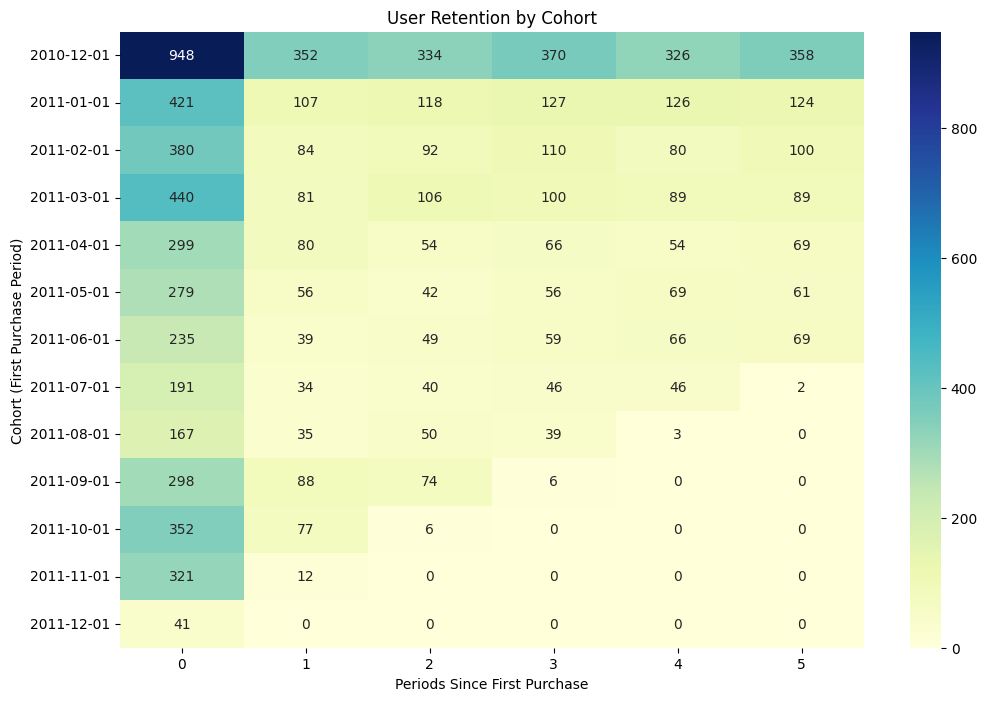

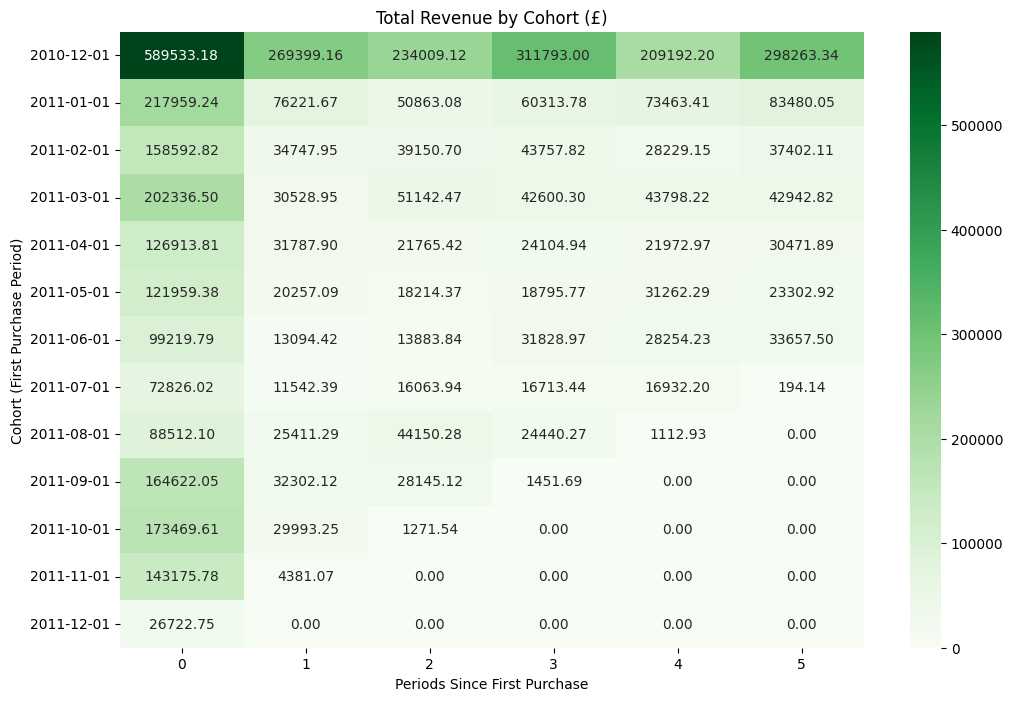

In [170]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cohort_heatmap(cohort_data, title, fmt='.0f', cmap='YlGnBu'):
    plt.figure(figsize=(12, 8))
    
    # Create a copy of the data with formatted date index
    plot_data = cohort_data.copy()
    
    # Format the datetime index to a more readable date format (e.g., 'Jan 2020')
    if isinstance(plot_data.index, pd.DatetimeIndex):
        plot_data.index = plot_data.index.strftime('%Y-%m-%d')
    
    # Plot the heatmap with formatted dates
    sns.heatmap(plot_data, annot=True, fmt=fmt, cmap=cmap)
    plt.title(title)
    plt.xlabel('Periods Since First Purchase')
    plt.ylabel('Cohort (First Purchase Period)')
    plt.show()

# Plot user retention cohort
plot_cohort_heatmap(user_cohorts.iloc[:, :6], 'User Retention by Cohort')

# Plot revenue cohort with different format for currency values
plot_cohort_heatmap(revenue_cohorts.iloc[:, :6], 'Total Revenue by Cohort (£)', fmt='.2f', cmap='Greens')

## Example with Nunique Aggregation

Here's an example of how to use the 'nunique' aggregation to analyze unique products or categories per cohort:

Number of Unique Products Purchased by Each Cohort:
period_number    0     1     2     3     4     5     6     7     8     9   \
first_period                                                                
2010-12-01     2435  1843  1796  1868  1880  1830  1880  1969  1980  2104   
2011-01-01     1856  1096  1102  1091  1125  1170  1018  1310  1414  1444   
2011-02-01     1794  1020   907  1007   902   974   961  1110  1228   969   
2011-03-01     1886   819  1002  1107   981  1001  1139  1365  1226   376   
2011-04-01     1710   872   583   765   731   951  1094   810   286     0   

period_number    10    11    12  
first_period                     
2010-12-01     2157  2282  1705  
2011-01-01     1564   239     0  
2011-02-01      130     0     0  
2011-03-01        0     0     0  
2011-04-01        0     0     0  


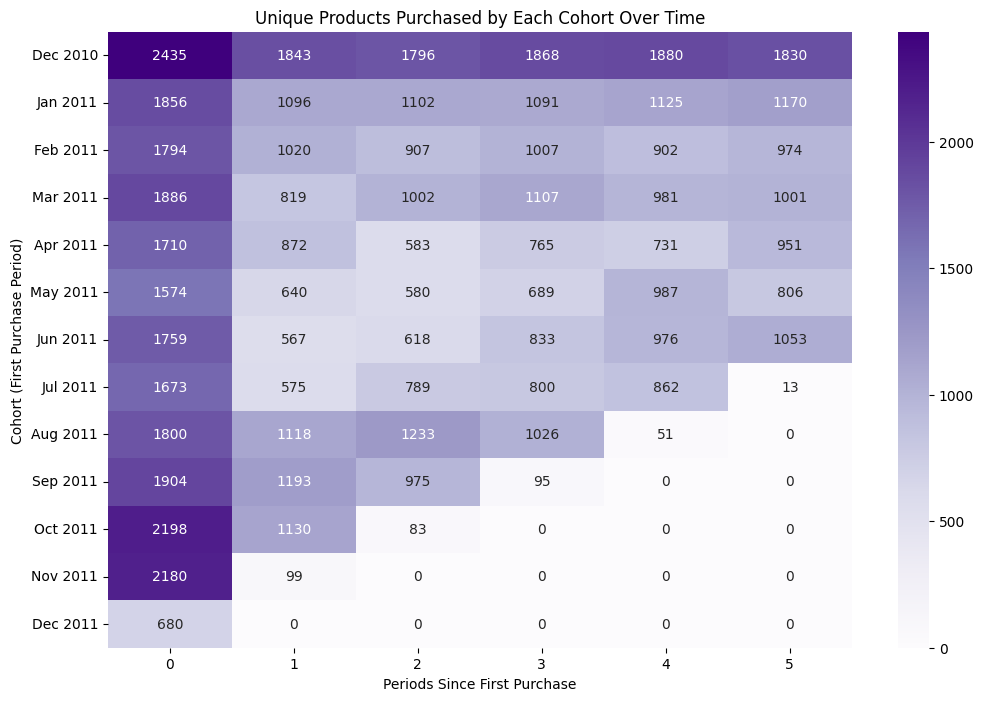

In [171]:
# Example: Count unique products purchased by each cohort over time
unique_products_cohort = generate_cohort_data(
    data=ecommerce_data,
    datetime_column_name='InvoiceDateTime',
    user_column_name='CustomerID',
    value_column_name='StockCode',  # Column containing product codes
    aggregation_function='nunique',  # Count unique products
    output_format='pivot'
)

print("Number of Unique Products Purchased by Each Cohort:")
print(unique_products_cohort.head())

# Visualize the unique products cohort
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
# Format the datetime index for better visualization
plot_data = unique_products_cohort.iloc[:, :6].copy()
if isinstance(plot_data.index, pd.DatetimeIndex):
    plot_data.index = plot_data.index.strftime('%b %Y')
    
sns.heatmap(plot_data, annot=True, fmt='.0f', cmap='Purples')
plt.title('Unique Products Purchased by Each Cohort Over Time')
plt.xlabel('Periods Since First Purchase')
plt.ylabel('Cohort (First Purchase Period)')
plt.show()